# Noise and Filters
## Noise in Images
* random noise
* periodic noise

### Gaussian Noise
white noise generally used when no prior knowledge about noise is available
$$
N(p; 0, \sigma_n^2) = \frac{1}{\sqrt{2 \pi \sigma_n^2}} \exp \left( - \frac{p^2}{2 \sigma_n^2} \right)
$$

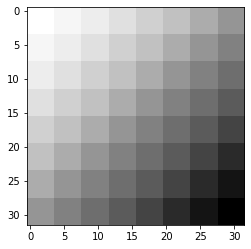

In [1]:
import numpy as np
import matplotlib.pyplot as plt

orig_img = np.zeros((32, 32, 1))
for i in range(8):
    for j in range(8):
        orig_img[i*4:(i+1)*4, j*4:(j+1)*4] = abs(i + j) / 16.
plt.imshow(orig_img, cmap="Greys")

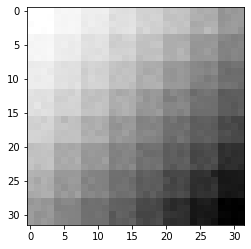

In [2]:
# add gaussian noise with s.d. of 0.05
gaussian_noise = np.random.normal(size=orig_img.shape) * 0.01
grid_gaussian = np.clip(orig_img + gaussian_noise, 0., 1.)
plt.imshow(grid_gaussian, cmap="Greys")

### Inpulsive Noise
Noise typically caused by malfunctioning element, signal transfer, A/D conversion, etc.

e.g., salt-and-pepper noise
$$
I_{obs} (i, j) =
  \begin{cases}
    I(i, j) & \alpha < l \\
    (1 - \beta) v_{\mathrm{min}} + \beta v_{\mathrm{max}} & \alpha \geq l
  \end{cases} \\
\mathrm{where} \quad \alpha, \beta \sim U(0, 1)
$$

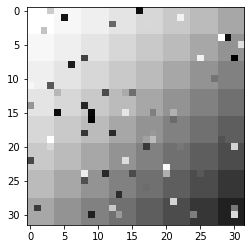

In [3]:
# add impulsive noise
impulsive_noise = np.where(np.random.uniform(size=(32, 32, 1)) < 0.95, orig_img, np.random.uniform(size=(32, 32, 1)))
grid_impulsive = np.clip(impulsive_noise, 0., 1.)
plt.imshow(grid_impulsive, cmap="Greys")

## Linear Filter
convolution of a image $I$ and a linear filter $A$
$$
I_A(i, j) = I * A = \sum_{k=-\frac{m}{2}}^{\frac{m}{2}} \sum_{l=-\frac{m}{2}}^{\frac{m}{2}} A(k, l) I(i - k, j - l)
$$

In [4]:
def conv2d(image, kernel):
    # kernel size should be an odd number
    assert kernel.shape[0] % 2 == 1 and kernel.shape[1] % 2 == 1
    # here, assume that the kernel is a square
    assert kernel.shape[0] == kernel.shape[1]
    
    m = kernel.shape[0]
    mdiv2 = m // 2
    h, w, c = image.shape
    
    # extend the image to apply a kernel to the edge of it
    extended_shape = [image.shape[0] + m - 1, image.shape[1] + m - 1, image.shape[2]]
    extended = np.empty(extended_shape)
    
    # center
    extended[mdiv2:-mdiv2, mdiv2:-mdiv2, :] = image
    for i in range(mdiv2):
        # edges
        extended[       i, mdiv2:mdiv2 + w, :] = image[ 0, :, :]
        extended[-(i + 1), mdiv2:mdiv2 + w, :] = image[-1, :, :]
        extended[mdiv2:mdiv2 + h,        i, :] = image[:,  0, :]
        extended[mdiv2:mdiv2 + h, -(i + 1), :] = image[:, -1, :]
    # corners
    extended[ :mdiv2,  :mdiv2, :] = image[ 0,  0, :]
    extended[ :mdiv2, -mdiv2:, :] = image[ 0, -1, :]
    extended[-mdiv2:,  :mdiv2, :] = image[-1,  0, :]
    extended[-mdiv2:, -mdiv2:, :] = image[-1, -1, :]
    
    # convolution
    # Most naive implementation: time complexity of O(HWCM^2)
    result = np.zeros_like(image)
    for i in range(h):
        for j in range(w):
            for k in range(-mdiv2, mdiv2 + 1):
                for l in range(-mdiv2, mdiv2 + 1):
                    for ch in range(c):
                        result[i, j, ch] += extended[i - k + mdiv2, j - l + mdiv2, ch] * kernel[mdiv2 + k, mdiv2 + l]
    return result
        

### Moving Mean Filter
The simplest linearfilter. Behave as a low-pass filter.


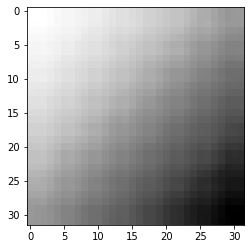

In [5]:
# apply moving mean filter to the image including gaussian noise
mmf_kernel = np.ones((3, 3), dtype=np.float32) / 9.
filtered = conv2d(grid_gaussian, mmf_kernel)
plt.imshow(filtered, cmap="Greys")

MMF reduces the noise but blurs the edges.

### Gaussian Filter
||Kernel||
|:----:|:----:|:----:|
| 1/16 | 2/16 | 1/16 |
| 2/16 | 4/16 | 2/16 |
| 1/16 | 2/16 | 1/16 |